In [1]:
using PyPlot
using Base.Test

## Utilities
δ(𝐱) = prod(map(x -> x ≈ 0. ? 1. : 0., 𝐱)) # Dirac delta
δ₌ = Σ -> (x -> exp(-x'/ Σ * x)) # approximate Dirac delta
;

# Sequential Latent Force Modelling of the Convection-Diffusion Equation for Source Identification

## Fluid Flow in Porous Media
... Darcy's law, etc.

## Hydrodynamic Solute Modelling

### Diffusion Equation
The concentration of solute particles in a system can be described in terms of their diffusion over time, with some dispersivity parameter related to the physical properties of the porous medium(/media) in the system; the chemical make-up of the solute; and other factors such as density, temperature, solvent properties. $\mathcal{D}(\mathbf{x})$ is a diffusion tensor, but may be represented as a scalar where it is constant and isotropic: $\mathcal{D} = \mathrm{diag}\{D, D, \ldots\}$
 
$$
    \frac{\partial}{\partial t}\mathcal{C}(\mathbf{x},t) = \nabla\cdot\left(\mathcal{D}(\mathbf{x})\nabla \mathcal{C}(\mathbf{x},t)\right)
$$

The diffusion equation is a generalised form of the heat equation. As such, the resulting solution for a homogeneous media is typically Gaussian in nature. An example of this can be seen in the analytic solution of the 1-D diffusion equation with constant diffusion and an instantaneous point injection $\mathcal{C}(x, 0) = m_0\delta(x - u_0)$, where $\delta$ is the Dirac delta function and $u_0$ is the source location, and $m_0$ is the mass of the injection:

$$
    \mathcal{C}(x,t) = \frac{m_0}{\sqrt{4\pi Dt}}\exp\left(-\frac{(x-u_0)^2}{4Dt}\right)
$$

The transport system defined here can be considered Fickian, in that it follows Fick's laws, and thus the dispersion of particles in the system can be assumed to be approximately proportionally Gaussian. In non-constant dispersivity, notably in heterogeneous media, there may be some convolution of the shape of the Gaussian.

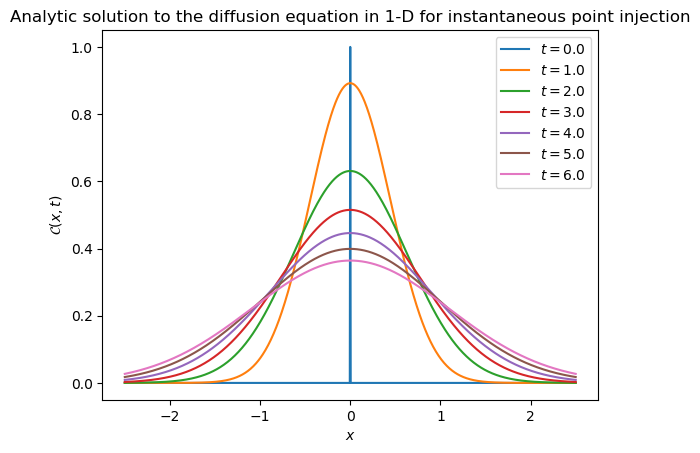

In [2]:
m₀, u₀, D = 1., 0., 0.1 # initial mass, source location and dispersivity coefficient

𝐱 = -2.5:0.005:2.5       # discrete sampling mesh of locations 𝐱
𝐭 = 1:6                 # discrete sampling times t = 1...6

# Analytic solution to diffusion equation
Cᴰ(x, t) = (m₀/√(4π*D*t)) * exp.(-(x - u₀).^2/(4D*t)) 

# Initial condition
C₀ = m₀.*map(x -> δ(x-u₀), 𝐱)
plot(𝐱, C₀, "-")

# Sample and plot solution at time t
for t ∈ 𝐭
    plot(𝐱, Cᴰ(𝐱, t), "-")
end

# Plot anotation
xlabel(L"$x$"), ylabel(L"$\mathcal{C}(x,t)$")
legend(labels=map(t -> string(L"$t=$", @sprintf("%2.1f",t)), [0 ; collect(𝐭)]))
title("Analytic solution to the diffusion equation in 1-D for instantaneous point injection");

### Convection-Diffusion Equation
While the diffusion equation describes how a substance will spread, in systems under the influence of flow fields there can be some velocity component describing some convection of the solute particles. This can be interpreted as a shift of the concentration at a rate proximately equal to the velocity $\mathbf{v}(\mathbf{x})$ of the underlying flow field.

$$
    \frac{\partial}{\partial t}\mathcal{C}(\mathbf{x},t) = \nabla\cdot\left(\mathcal{D}(\mathbf{x})\nabla \mathcal{C}(\mathbf{x},t)\right) + \nabla\cdot\left(\mathbf{v}(\mathbf{x})\mathcal{C}(\mathbf{x}, t)\right)
$$

The first term on the right-hand side of the equation is the diffusion term, and the second term describes the convection. Where $\mathbf{v} = \mathbf{0}$, this is trivially the diffusion equation, and where $\mathcal{D} = \mathbf{0}$, it is the continuity equation.

With injection of solute into the system, the convection-diffusion equation can be adapted with an input term $u(\mathbf{x}, t)$:

$$
    \frac{\partial}{\partial t}\mathcal{C}(\mathbf{x},t) = \nabla\cdot\left(\mathcal{D}(\mathbf{x})\nabla \mathcal{C}(\mathbf{x},t)\right) + \nabla\cdot\left(\mathbf{v}(\mathbf{x})\mathcal{C}(\mathbf{x}, t)\right) + u(\mathbf{x}, t)
$$

Note that in system where the velocity field is predominantly a horizontal flow field, and the solute is subject to mechanical dispersion (to a significantly greater degree than ionic diffusion), the model may be termed the _advection-dispersion model_.

As an analogue to the example above, the analytic solution to the 1-D convection-diffusion equation with instantaneous point injection is given by

$$
    \mathcal{C}(x,t) = \frac{m_0}{\sqrt{4\pi Dt}}\exp\left(-\frac{(x-u_0 - v)^2}{D}\right)
$$

Where $D$ and $v$ are constant, and the initial condition is given by $\mathcal{C}(x, 0) = m_0\delta(x - u_0)$.

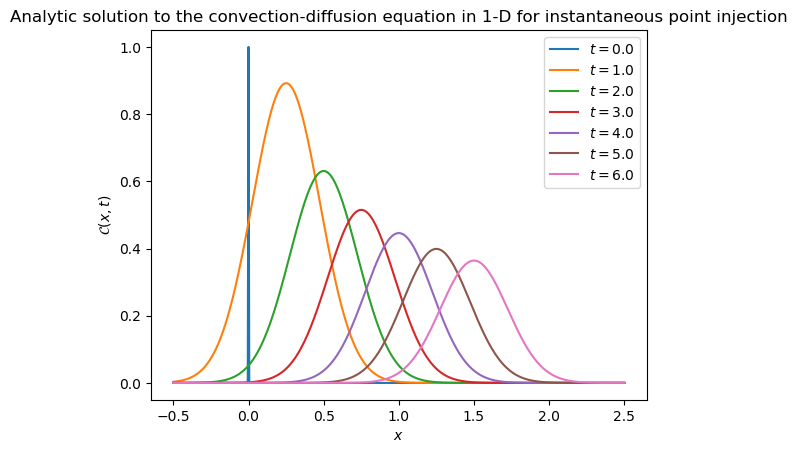

In [3]:
m₀, u₀, D, v = 1., 0., 0.1, 0.25 # initial mass, source location, dispersivity coefficient and velocity

𝐱 = -0.5:0.005:2.5       # discrete sampling mesh of locations 𝐱
𝐭 = 1:6                 # discrete sampling times t = 1...6

# Analytic solution to advection-dispersion with point injection
Cᴬ(x, t) = (m₀/√(4π*D*t)) * exp.(-(x - u₀ - v*t).^2/D)

# Initial condition
C₀ = m₀.*map(x -> δ(x-u₀), 𝐱)
plot(𝐱, C₀, "-")

# Sample and plot solution at time t
for t ∈ 𝐭
    plot(𝐱, Cᴬ(𝐱, t), "-")
end

# Plot anotation
xlabel(L"$x$"), ylabel(L"$\mathcal{C}(x,t)$")
legend(labels=map(t -> string(L"$t=$", @sprintf("%2.1f",t)), [0 ; collect(𝐭)]))
title("Analytic solution to the convection-diffusion equation in 1-D for instantaneous point injection");

## Sequential Latent Force Modelling

### Latent Force Model

Consider the convection-diffusion equation with some spatio-temporal input function $u(\mathbf{x},t)$ describing, for example injection (or alternatively suction). A latent force interpretation would describe this as a stochastic differential equation, with the input $u$ modelled as a Gaussian process.

$$
    \frac{\partial}{\partial t}\mathcal{C}(\mathbf{x},t) = \nabla\cdot\left(\mathcal{D}(\mathbf{x})\nabla \mathcal{C}(\mathbf{x},t)\right) + \nabla\cdot\left(\mathbf{v}(\mathbf{x})\mathcal{C}(\mathbf{x}, t)\right) + u(\mathbf{x}, t)
$$

$$
    u(\mathbf{x},t) \sim \mathcal{GP}\left(m_u(\mathbf{x}, t), \kappa_u(\mathbf{x},\mathbf{x}';t,t')\right)
$$




In [4]:
# ...

---

### Evolutionary Model
Assuming a constant (scalar) dispersivity, and constant velocity field, where now the concentration is denoted $f \triangleq C(\mathbf{x}, t)$

$$
    \frac{\partial}{\partial t}f(\mathbf{x},t) = \left[D\nabla\cdot\left(\nabla + \frac{\mathbf{v}}{D}\mathcal{I}\right)\right]f(\mathbf{x},t) + \mathbf{C}_u\mathbf{u}(\mathbf{x},t)
$$

$$
    \frac{\partial}{\partial t}\mathbf{u}(\mathbf{x},t) + \mathscr{A}_u\mathbf{u}(\mathbf{x},t) + \mathbf{B}_uw(\mathbf{x},t)
$$

Where $w(\mathbf{x},t)$ is a white noise process and $\mathbf{u}$ represents the reparameterisation of GP $u(\mathbf{x},t)$ based on the covariance function used to model it.

The differential operator of the evolutionary process in $f(\mathbf{x},t)$ is here defined $\mathscr{A}_f = D\nabla\cdot\left(\nabla + (\mathbf{v}/D)\mathcal{I}\right)$, where $\nabla$ is the gradient operator and $\mathcal{I}$ is the identity operator.

### Hilbert Space Approximation

To approximate the above equation, a numerical approach is required. Using Galerkin's method of approximating the solution in a finite space representated by a set of basis functions, such that a function $g(\mathbf{x},t)$ subject to a PDE can be represented as the sum of basis functions with true representation in the limit of the number of basis functions

$$
    g(\mathbf{x},t) = \sum^\infty_{i=1} g_i(t)\phi_i(\mathbf{x})
$$

Consider the eigenfunction representation of a linear operator $\mathscr{D}$: $\mathscr{D}\phi_i = \lambda_i\phi_i$, where $\phi_i$ is an _eigenfunction_ of $\mathscr{D}$ on some defined function space and $\lambda_i$ is its corresponding scalar _eigenvalue_.

Representing the evolutionary operator $\mathscr{A}_f$ in this manner leads to a steady-state PDE over an eigenfunction

$$
    \mathscr{A}_f\phi_i = \lambda_i\phi_i
$$

$$
\Rightarrow \left[D\nabla\cdot\left(\nabla + (\mathbf{v}/D)\mathcal{I}\right)\right]\phi_i - \lambda_i\phi_i = 0
$$
$$
\Rightarrow D\nabla^2\phi_i + \nabla\cdot\left(\mathbf{v}\phi_i\right) - \lambda_i\phi_i = 0
$$

## Model

Consider a 2-D convection-diffusion equation with a constant flow field and scalar isotropic dispersivity, and unknown injection that can be sampled from a spatio-temporal Gaussian process with unknown mean and variance.

$$
    \frac{\partial}{\partial t}f(\mathbf{x},t) = D\nabla^2f(\mathbf{x},t) + \nabla\cdot\left(\mathbf{v}\mathcal{f}(\mathbf{x}, t)\right) + u(\mathbf{x}, t)
$$

Let the solution be defined on a 2-D space $\Omega = [-L_x, L_x] \times [-L_y, L_y]$, with Dirichlet boundary conditions $f(\mathbf{x}, t) = 0\ \forall\ \mathbf{x} \in \partial\Omega$.

Using the eigenfunction basis representation of the differential operator describing the evolution of $f$, the steady-state PDE describing the form of bases $\phi_i(\mathbf{x})$ can be defined:

$$
    \frac{\partial^2\phi_i}{\partial x^2} + \frac{\partial^2\phi_i}{\partial y^2} + \frac{v_x}{D}\frac{\partial \phi_i}{\partial x} + \frac{v_y}{D}\frac{\partial \phi_i}{\partial y} - \frac{\lambda_i}{D}\phi_i(\mathbf{x}) = 0
$$

Substituting $\phi_i(\mathbf{x}) = \exp\left(-(\mathbf{v}\cdot\mathbf{x})/2D\right)\varphi_i(\mathbf{x})$ gives the equation in the form of the homogeneous Helmholtz equation:

$$
    \frac{\partial^2\varphi_i}{\partial x^2} + \frac{\partial^2\varphi_i}{\partial y^2} -\lambda'_i\varphi_i(\mathbf{x}) = 0
$$

Where now the modified eigenfunctions $\varphi_i$ are equivalent to those of the Laplace operator in 2-D, and the modified eigenvalues are defined $\lambda'_i = \frac{\lambda_i}{D} + \frac{1}{4D^2}\|\mathbf{v}\|^2$. For the Dirichlet boundary conditions described, the eigenvectors of the evolutionary convection-diffusion model non-unique, and can be described in the form, where $\Omega = [0,1]\times[0,1]$:

...

In [5]:
## Prototypes
# proto_λ = L -> (n -> sum(π*n./(2L)))
# proto_ϕ = L -> (n -> (x -> prod(sqrt.(1./L).*sin.(π*n.*(x + L)./(2L)))))

proto_λ = (L, D, v) -> (n -> sum(π*n./(2L))*D - (v⋅v)/4D)
proto_ϕ = (L, D, v) -> (n -> (x -> prod(sqrt.(1./L).*sin.(π*n.*(x+L)./(2L))).*exp.((v⋅x)/2D)))

(::#23) (generic function with 1 method)

### Parameter setup

- $\Omega = [-2, 2] \times [-0.5, 0.5]$
- $\mathbf{v} = [-1.5, -0.2]^\text{T}$
- $D = 0.1$

In [22]:
L, D, 𝐯 = [1.; 1.], 1, [-5;0.] # Advection-dispersion
#L, D, 𝐯 = [1.; 1.], 1e-3, [0.;0.] # Heat equation

#λ, ϕ = proto_λ(L), proto_ϕ(L)
ϕ, λ = proto_ϕ(L, D,𝐯), proto_λ(L, D, 𝐯);

### Plot flow field in $\Omega$

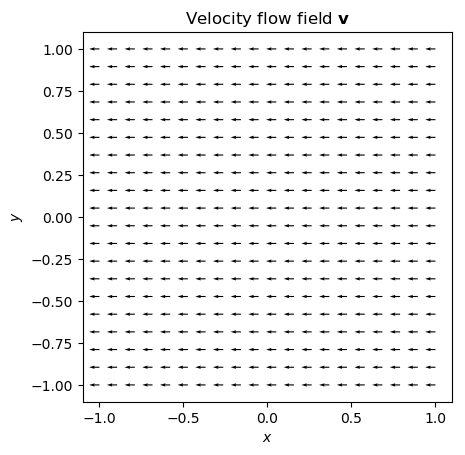

In [23]:
nₓ = 20
𝑥,𝑦 = linspace(-L[1], L[1], nₓ), linspace(-L[2], L[2], nₓ)

quiver(𝑥, 𝑦, reshape(map(_ -> 𝐯[1], 1:nₓ*nₓ), nₓ, nₓ), reshape(map(_ -> 𝐯[2], 1:nₓ*nₓ), nₓ, nₓ))

function set_layout()
    axis(:square)
    xlim(-0.1-L[1], L[1]+0.1), ylim(-0.1-L[2], L[2]+0.1)
    xlabel(L"$x$"), ylabel(L"$y$")
end

set_layout()

title(L"Velocity flow field $\mathbf{v}$");

### Discretise system

Resolution: $n_x = 200 \times 200$

In [24]:
nₓ = 200

𝑥,𝑦 = linspace(-L[1], L[1], nₓ), linspace(-L[2], L[2], nₓ)

𝐱 = [[xᵢ;xⱼ] for xᵢ ∈ 𝑥 for xⱼ ∈ 𝑦];

## Map $\Omega$ to basis function representation

- $N=100$ basis functions
- $f_n, \lambda_n$ define N eigenfunctions and corresponding eigenvectors

In [25]:
## Create basis functions
N = 100 # maximum number of basis functions

## Generate aribtrary number of eigenvalues (e.g. 10x10)
𝐧 = [[nᵢ; nⱼ] for nᵢ ∈ 1:50 for nⱼ ∈ 1:50]
λₙ = map(λ, 𝐧)
            
## Sort in descending order and get N most principal eigenvalues 
ix = sortperm(λₙ)
𝐧  = 𝐧[ix[1:N]]

## Generate N eigenvalues and corresponding eigenfunctions evaluated on 𝐱 ∈ Ω
λₙ = map(λ, 𝐧)
fₙ = map(n -> map(ϕ(n), 𝐱), 𝐧)
            
println(@sprintf("Eigenvalues λₙ is an %s with dimension %s",typeof(λₙ), string(size(λₙ))))
println(@sprintf("Evaluated eigenfunctions fₙ is an %s with dimension %s and internal dimensions %s", typeof(fₙ), string(size(fₙ)), string(size(fₙ[1]))))

Eigenvalues λₙ is an Array{Float64,1} with dimension (100,)
Evaluated eigenfunctions fₙ is an Array{Array{Float64,1},1} with dimension (100,) and internal dimensions (40000,)


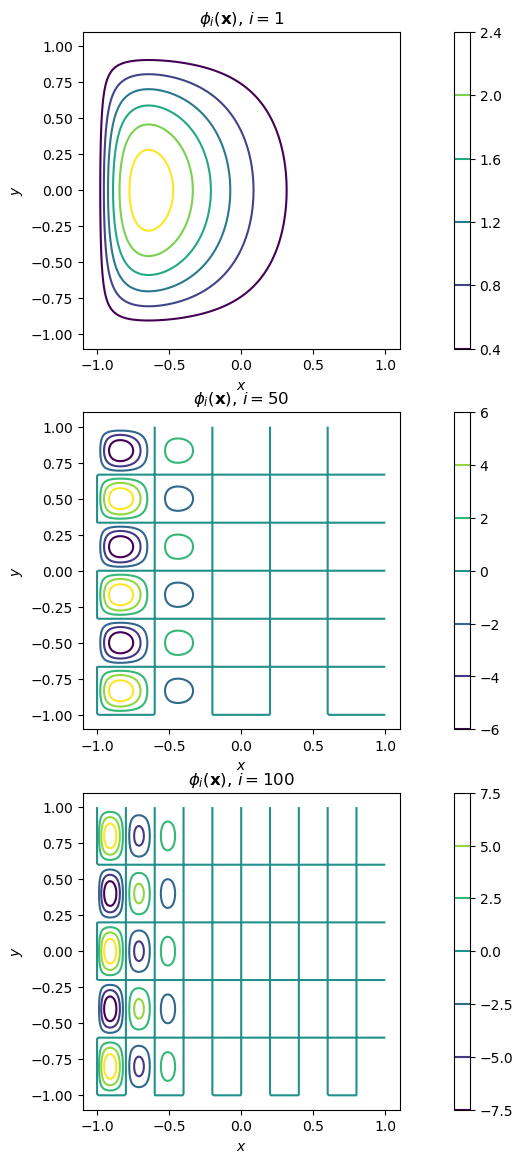

In [26]:
## Plot example basis functions

figure(figsize=(14, 14))

for (j,i) ∈ enumerate([1, round(Int, N/2), N])
    subplot(310 + j)
    contour(𝑥, 𝑦, reshape(fₙ[i],nₓ,nₓ))
    
    set_layout()
    
    title(string(L"$\phi_i(\mathbf{x})$, $i=$", i));
    colorbar()
end

### Inner product space defined by basis functions

$$
    \left\langle f, g\right\rangle_\phi = \int_{\Omega}\phi_f(\mathbf{x})\phi_g(\mathbf{x})\exp\left(\frac{\mathbf{v}\cdot\mathbf{x}}{D}\right)\partial\Omega
$$

In [27]:
## Check orthogonality

# Inner product definition
𝑱ᵩ = map(𝑥 -> exp(-(𝐯⋅𝑥)/D), 𝐱)
#𝑱ᵩ = 1.
⋆(x, y) = (𝑥[2] - 𝑥[1]) * (𝑦[2] - 𝑦[1]) * sum(x.*y.*𝑱ᵩ)

@testset "Orthogonality" begin
    @testset "Diagonal elements" for i ∈ 1:N
        @test fₙ[i] ⋆ fₙ[i] ≈ 1. atol=1e-14
    end
    @testset "Upper elements" for i ∈ [[i_,j_] for i_ ∈ 1:N for j_ ∈ i_+1:N]
        @test fₙ[i[1]] ⋆ fₙ[i[2]] ≈ 0. atol=1e-14
    end
    @testset "Upper elements" for i ∈ [[i_,j_] for i_ ∈ 1:N for j_ ∈ 1:i_-1]
        @test fₙ[i[1]] ⋆ fₙ[i[2]] ≈ 0. atol=1e-14
    end
end;

Test Summary: |  Pass  Total
Orthogonality | 10000  10000


In [28]:
fₙ[1] ⋆ fₙ[1] ≈ 1.


true

In [29]:
σ₁, σ₂ = 100., 100.
aₜ, bₜ = [0.15, 0.5]

𝑢(t) = (1 + exp.(σ₁*(aₜ - t))).^(-1) .* (1 + exp.(σ₂*(t - bₜ))).^(-1)

𝑢 (generic function with 1 method)

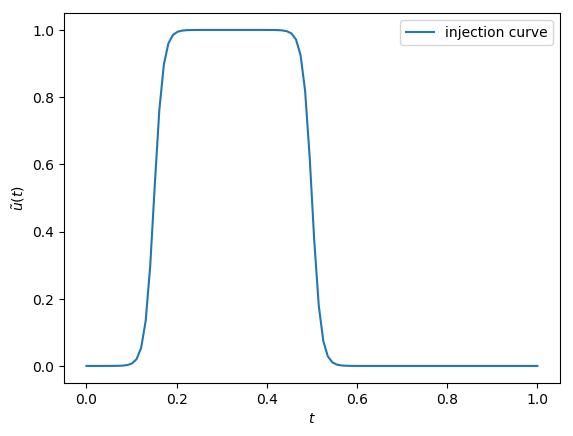

In [30]:
nₜ = 100
𝐭 = linspace(0., 1., nₜ)

plot(𝐭, 𝑢(𝐭), "-")
xlabel(L"$t$"), ylabel(L"$\tilde{u}(t)$")
legend(labels=["injection curve"]);

In [31]:
u₀ = [0.0 ; 0.0]
m₀ = 100.
Σ  = 1e-1

u(𝐱, t) = m₀ * map(x -> δ₌(Σ)(x - u₀), 𝐱) .* 𝑢(t) ./ sum(𝑢(𝐭))
𝐮ₜ = map(t -> u(𝐱, t), 𝐭)

uₘₐₓ, uₘᵢₙ = maximum(map(maximum, 𝐮ₜ)), minimum(map(minimum, 𝐮ₜ));

## Map input to Hilbert space representation

In [32]:
# Map input to Hilbert space
𝐮ᵩ = map(uₜ -> map(ϕᵢ -> uₜ ⋆ ϕᵢ, fₙ), 𝐮ₜ)

# Remap Hilbert space representation to Cartesian space
𝐮ₚ = [sum([λᵢ * ϕᵢ for (λᵢ, ϕᵢ) ∈ zip(uᵩ, fₙ)]) for uᵩ ∈ 𝐮ᵩ]

vˣ, vʸ = 𝐯[1]*ones(nₓ*nₓ), 𝐯[2]*ones(nₓ*nₓ)
𝑣ˣᵩ = map(ϕᵢ -> vˣ ⋆ ϕᵢ, fₙ)
𝑣ʸᵩ = map(ϕᵢ -> vʸ ⋆ ϕᵢ, fₙ)

𝐯ₚ = sum([[λˣ * ϕᵢ, λʸ * ϕᵢ] for (λˣ, λʸ, ϕᵢ) ∈ zip(𝑣ˣᵩ, 𝑣ʸᵩ, fₙ)])
;

## Define an example input function and approximately solve the system

Here, the input function will be known, so the solution is deterministic. The solution will be used to produce synthetic measurements.

Consider the input function

$$
u(\mathbf{x},t) = m_0\delta^\approx_{\sigma_\delta}(\mathbf{x}-\mathbf{u}_0)\frac{\tilde{u}(t)}{\int \tilde{u}(t)\mathrm{d}t}
$$

Where $\delta^\approx_{\sigma_\delta}(\mathbf{x})$ is the approximate Dirac delta function as a multivariate Gaussian centered on $\mathbf{x}$ with covariance $\sigma^2_\delta$, and where $\tilde{u}(t)$ is the injection curve:

$$
\tilde{u}(t) = \left(1 + \exp\left(\sigma_{\gamma_1}(a_t - t)\right)\right)^{-1}\left(1 + \exp\left(\sigma_{\gamma_2}(t - b_t)\right)\right)^{-1}
$$

Where $a$ and $b$ are injection start and stop times, respectively, and $\sigma_{\gamma_1}$ and $\sigma_{\gamma_2}$ describe the inverse delay response of the injection start and end respectively &ndash; the higher the value of $\sigma_\gamma$, the sharper the change.

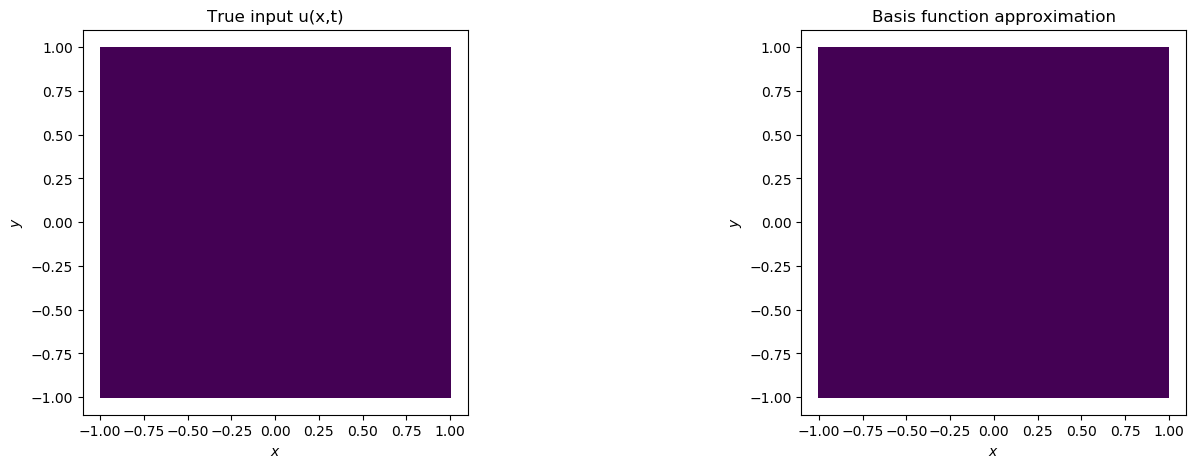

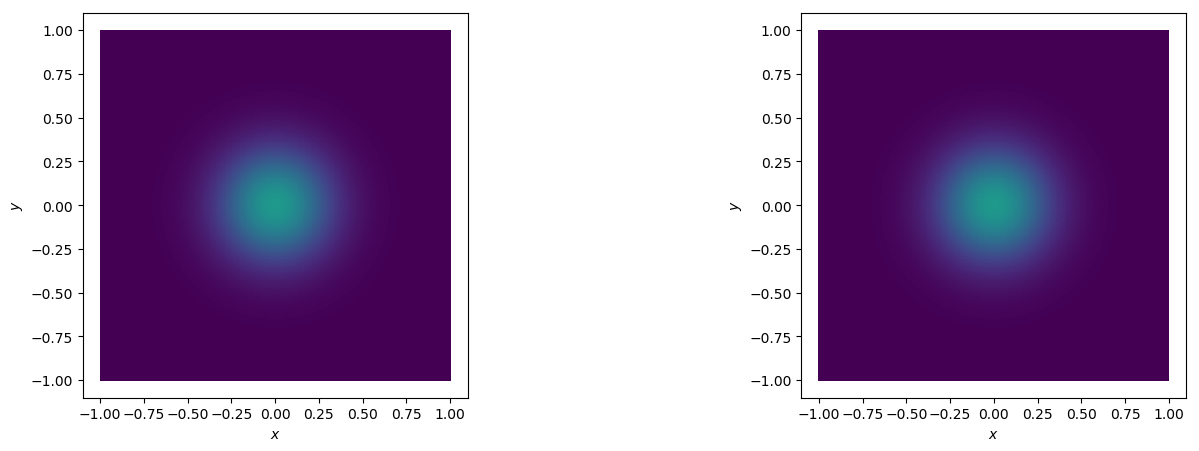

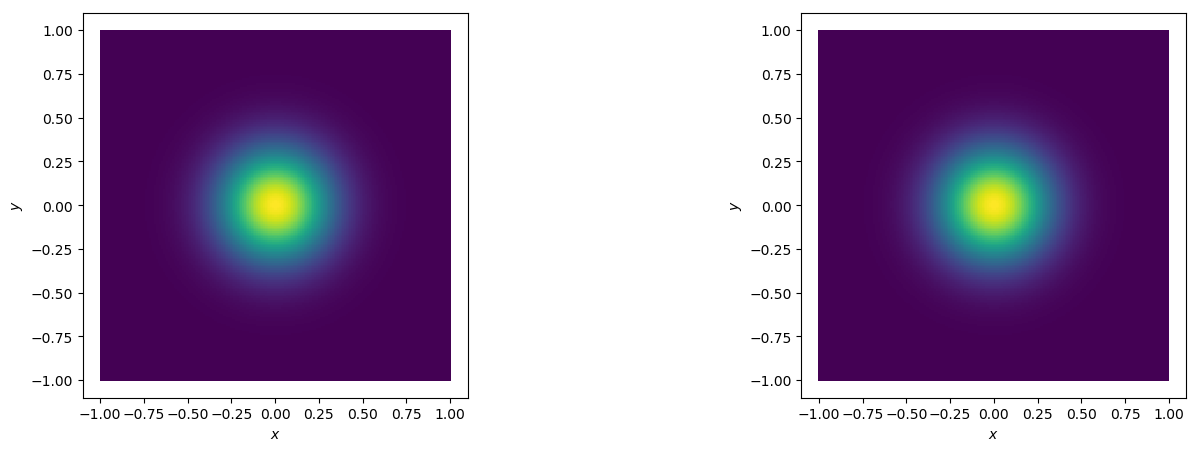

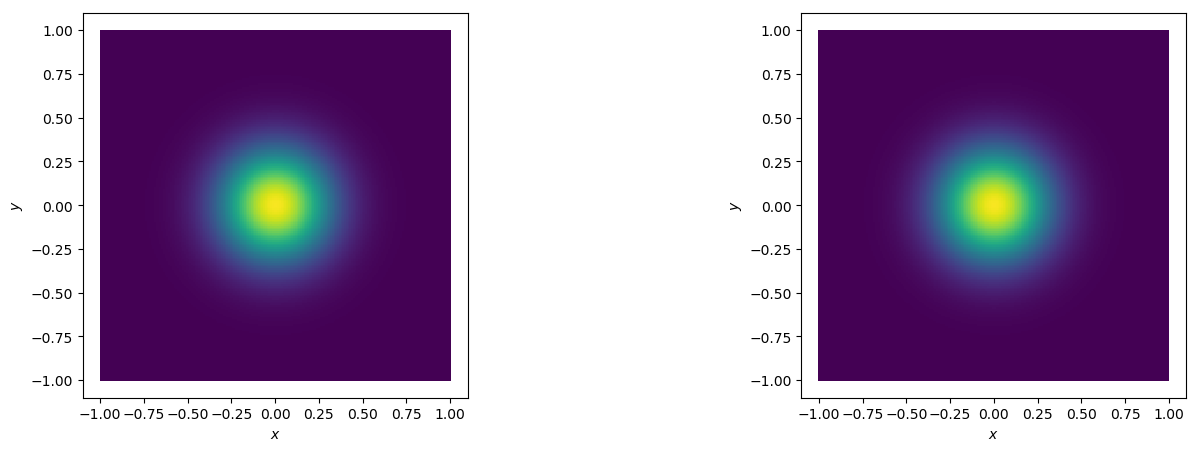

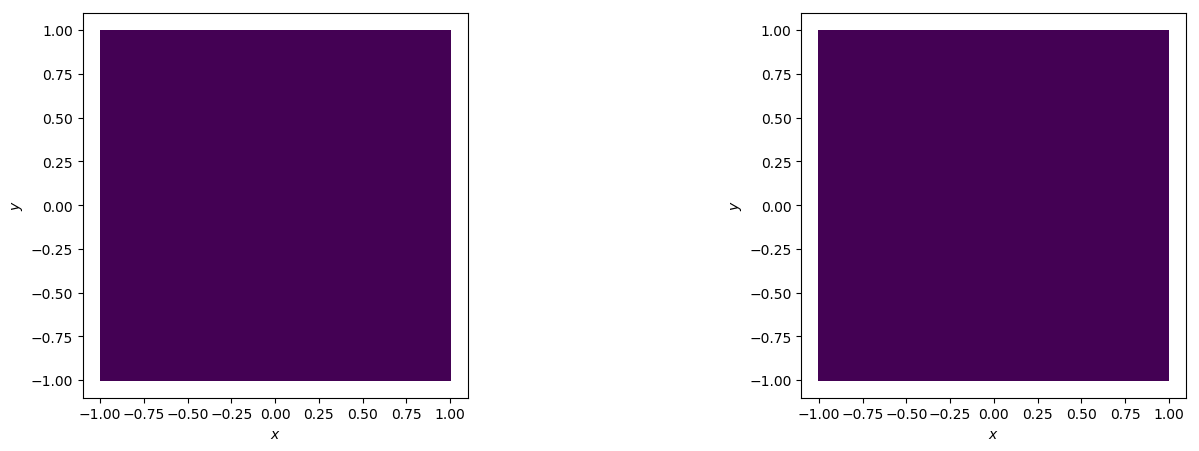

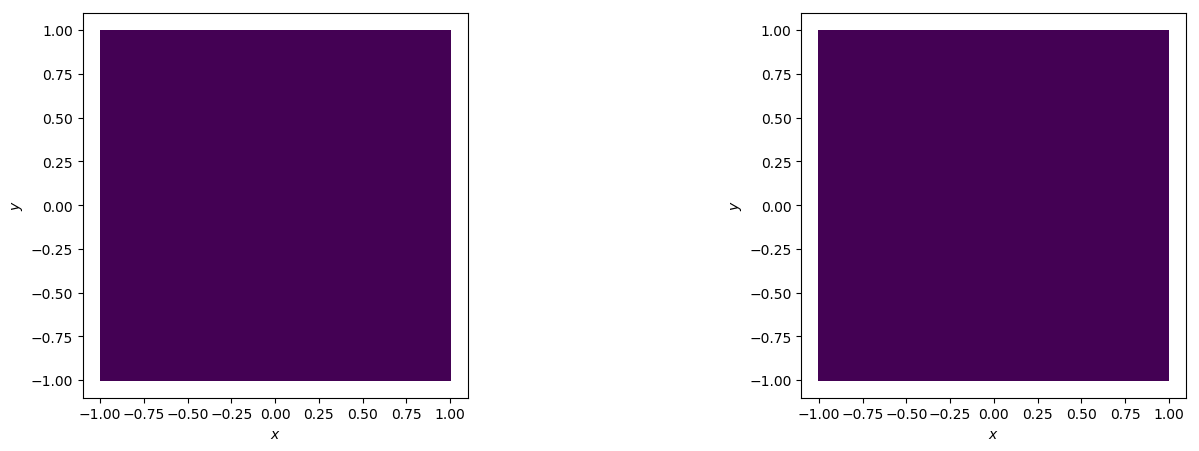

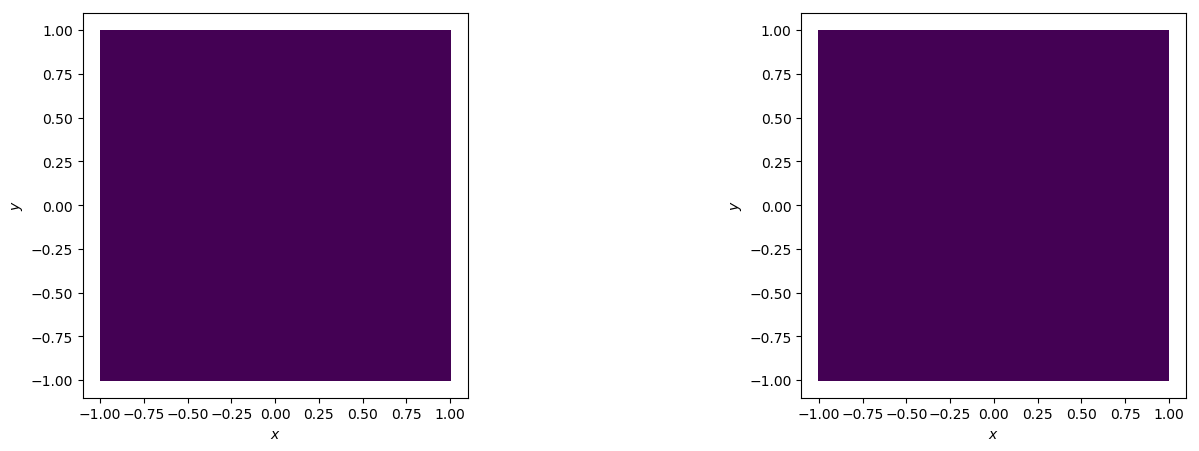

In [33]:
c⁺, c⁻ = uₘₐₓ, uₘᵢₙ
logcontour = (x,y,z) -> contour(x, y, log.(z + 1.), linspace(log(c⁻ + 1.), log(c⁺ + 1.), 6))

function plot_u(x,y,z; _contour=:true, c⁺ = uₘₐₓ, c⁻ = uₘᵢₙ, logarithm=:true)
    
    if logarithm == :true
        zₗ = log.(z + 1.)
        c⁺, c⁻ = log(c⁺ + 1.), log(c⁻ + 1.)
    else
        zₗ = z
    end
    
    if _contour == :true
        contour(x, y, zₗ, linspace(c⁻, c⁺, 6))
    else
        pcolor(x, y, zₗ)
        clim(c⁻, c⁺)
    end
    
    set_layout()
    
end

for k ∈ 1:15:nₜ # !! this looks better with a wider spread on the δ₌ function, e.g. Σ=0.1
    figure(figsize=(17, 5))
    
    subplot(121)
    plot_u(𝑥, 𝑦, reshape(𝐮ₜ[k], nₓ, nₓ), _contour=:false, logarithm=:false)
    k == 1 ? title("True input u(x,t)") : nothing
   
    subplot(122)
    plot_u(𝑥, 𝑦, reshape(𝐮ₚ[k], nₓ, nₓ), _contour=:false, logarithm=:false)
    k == 1 ? title("Basis function approximation") : nothing
    
end

## State Space Model Representation

$$
    \frac{\partial}{\partial t}\mathbf{f}(\mathbf{x}, t) = \mathscr{A}_f\mathbf{f}(\mathbf{x},t) +  \mathbf{C}_u\mathbf{u}(\mathbf{x},t)
$$

$$
    \frac{\partial}{\partial t}\mathbf{u}(\mathbf{x}, t) = \mathscr{A}_u\mathbf{u}(\mathbf{x},t) + \mathbf{B}_uw(t)
$$

$$
    \mathbf{y}_{t} = \mathbf{H}\mathbf{f}(\mathbf{x},t) + \nu_t
$$

### Process Model
$\mathbf{F} = \mathrm{diag}\left[-D\lambda(\mathbf{n})\right]$

$\mathbf{L} = \mathbf{I}$

$\mathscr{U} = \exp\left(\Delta_t\begin{bmatrix}\mathbf{F} & \mathbf{L} \\ \mathbf{0} & \mathbf{0}\end{bmatrix}\right)$

$\mathscr{A} = \mathscr{U_{1:n;1:n}}, \qquad \mathscr{B}_{1:n;n+1:2n}$


In [34]:
ℱ = [ diagm(-D.*λₙ) eye(N); zeros(N, 2N)]

Δₜ = 𝐭[2] - 𝐭[1]
𝒰 = expm(Δₜ * ℱ)

𝒜, ℬ = 𝒰[1:N, 1:N], 𝒰[1:N, N+1:end];

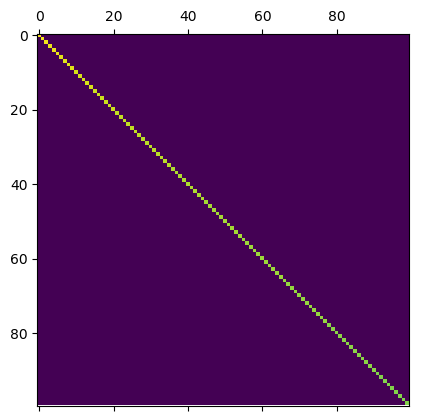

PyObject <matplotlib.image.AxesImage object at 0x7efc2786ad68>

In [35]:
matshow(𝒜)

### Solving the evolutionary PDE

Solve the convection-diffusion equation in basis function space using SSM and map back to $\Omega$

In [36]:
𝒇ᵩ = Array{typeof(𝐮ᵩ[1])}(nₜ)  # Solution in basis space over which the evolutionary model is performed
𝒇ₚ = Array{typeof(𝐮ₚ[1])}(nₜ) # Approximate solution mapped into regular representation

𝑓ₜ = zeros(N) # initial condition
for k = 1:nₜ
    𝑓ₜ = 𝒜 * 𝑓ₜ + ℬ * 𝐮ᵩ[k] # prediction
    
    𝒇ᵩ[k] = 𝑓ₜ
    
    𝒇ₚ[k] = sum([λ * ϕᵢ for (ϕᵢ, λ) ∈ zip(fₙ, 𝑓ₜ)])
end

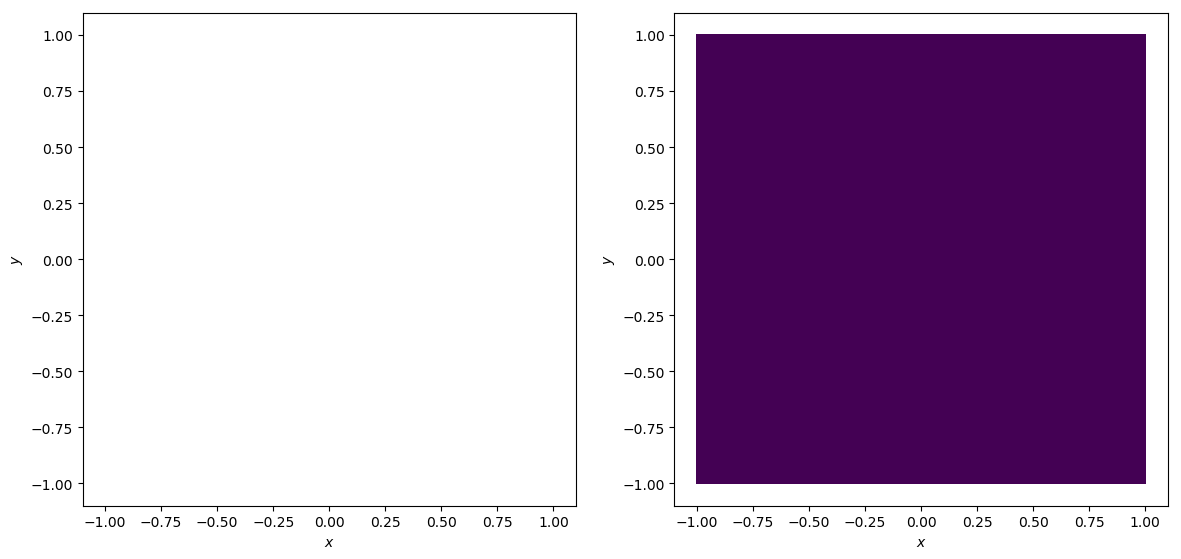

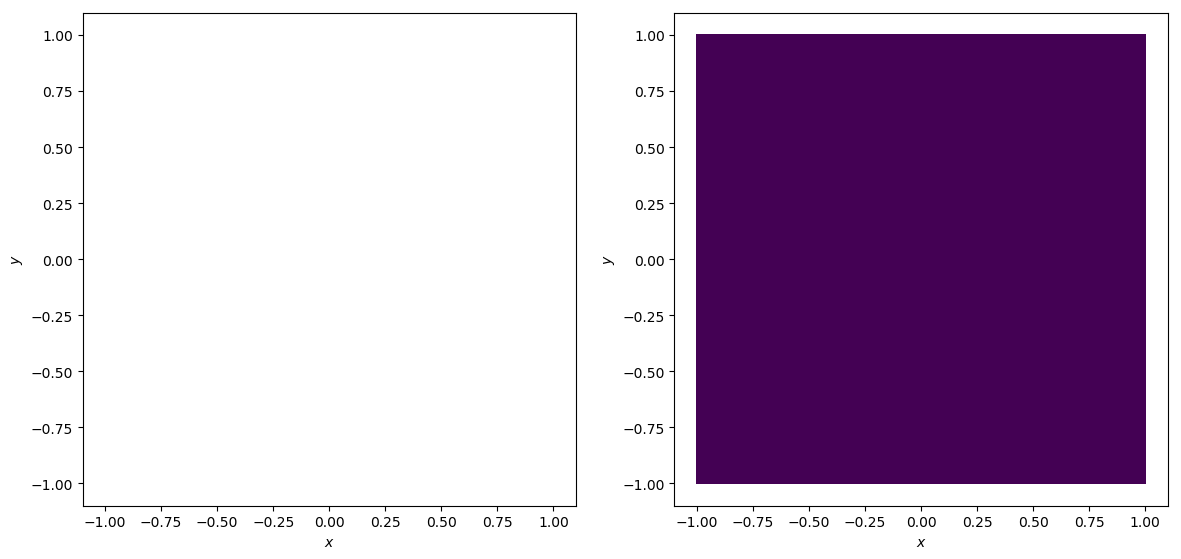

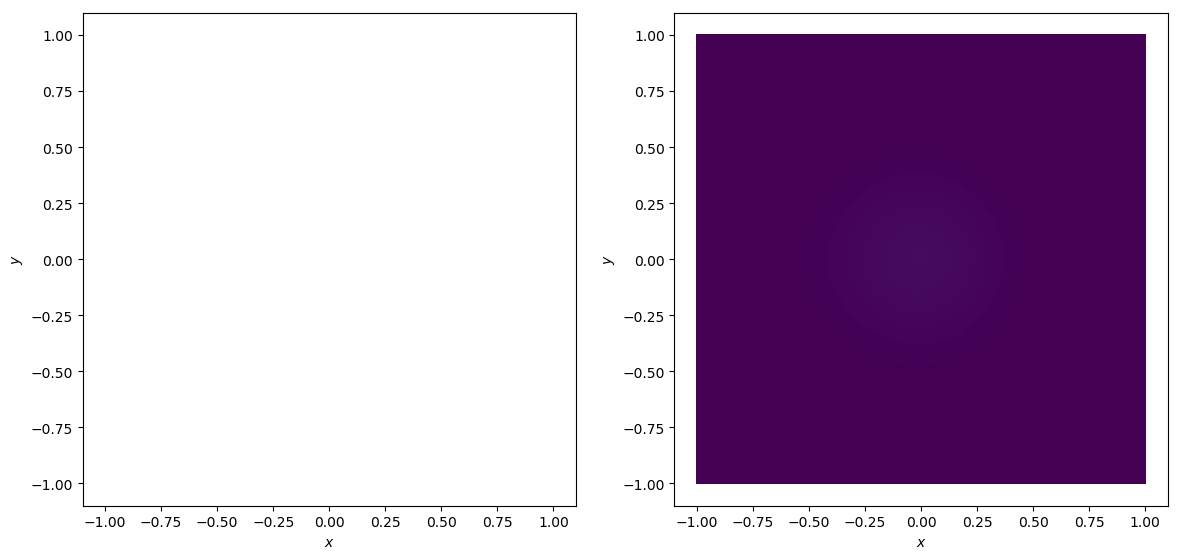

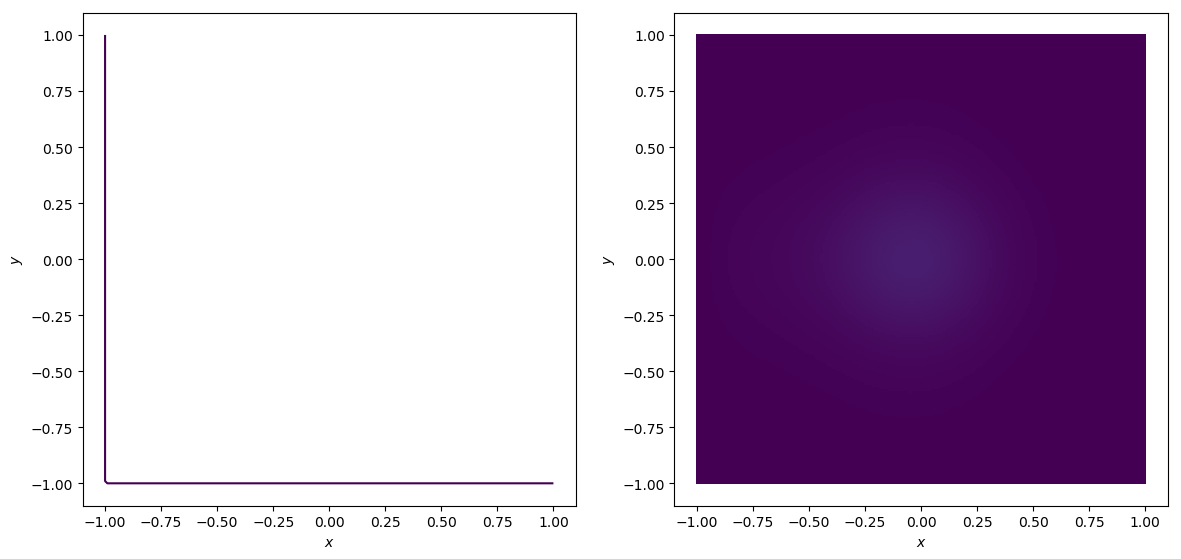

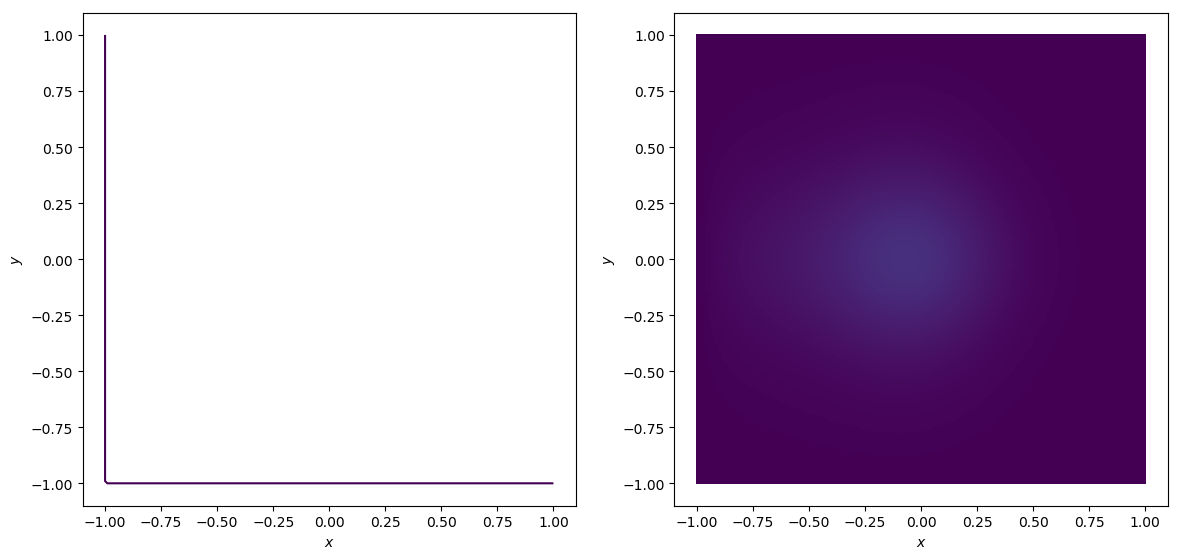

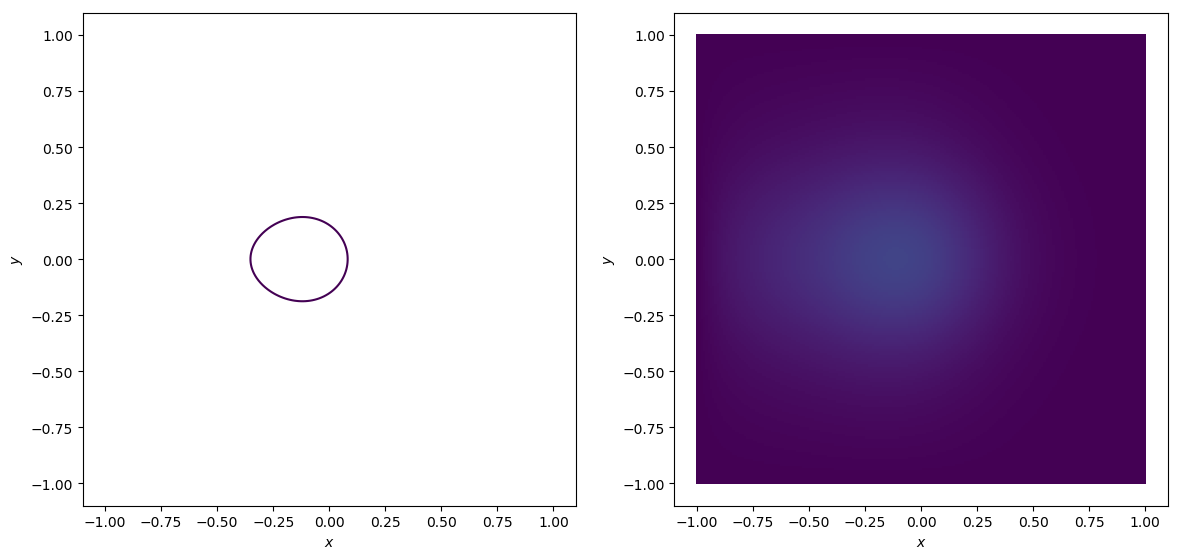

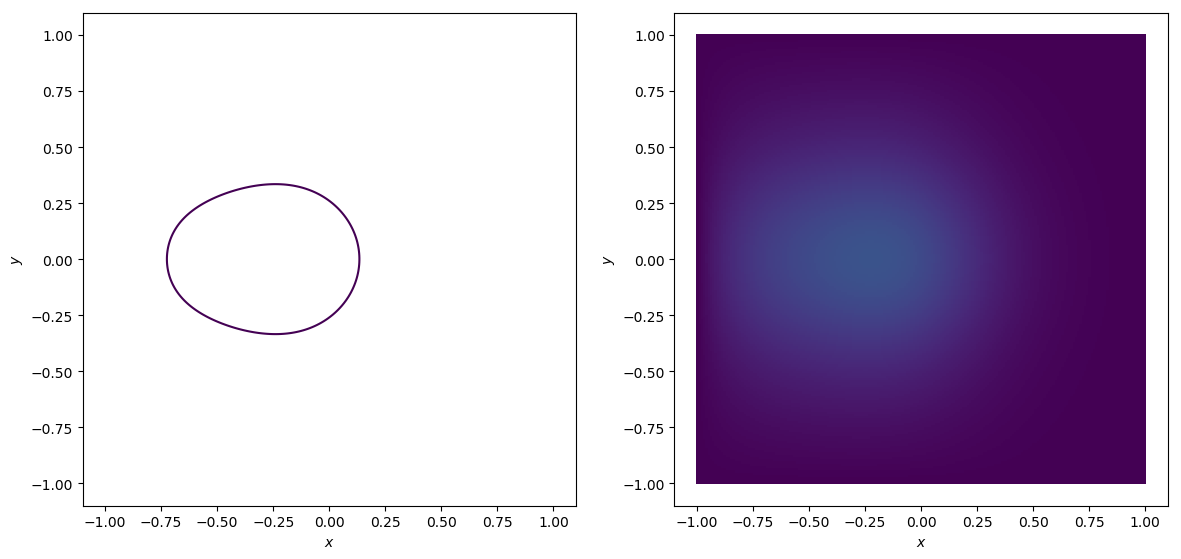

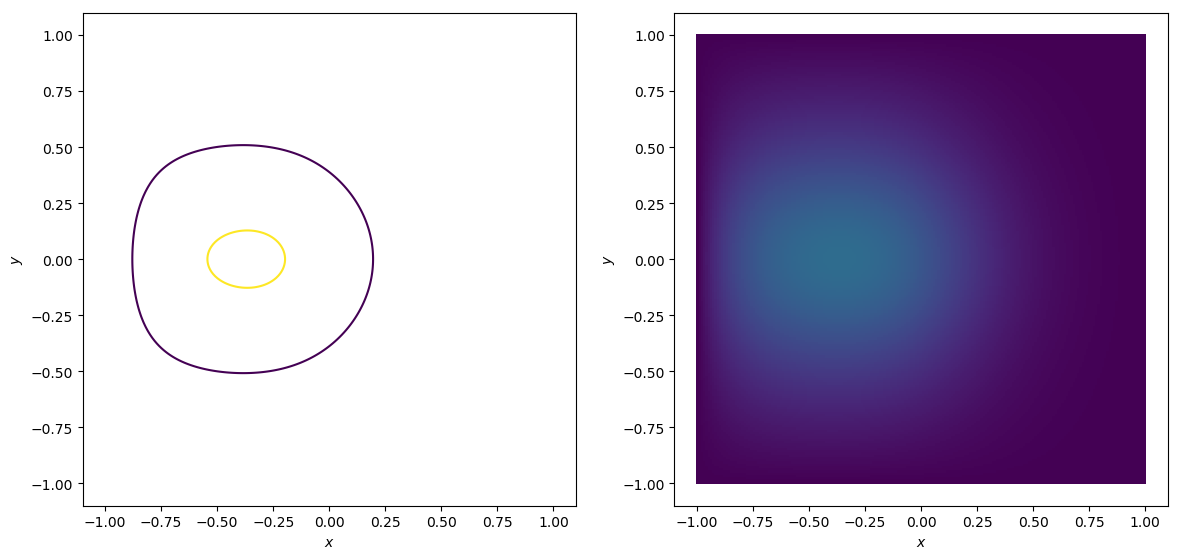

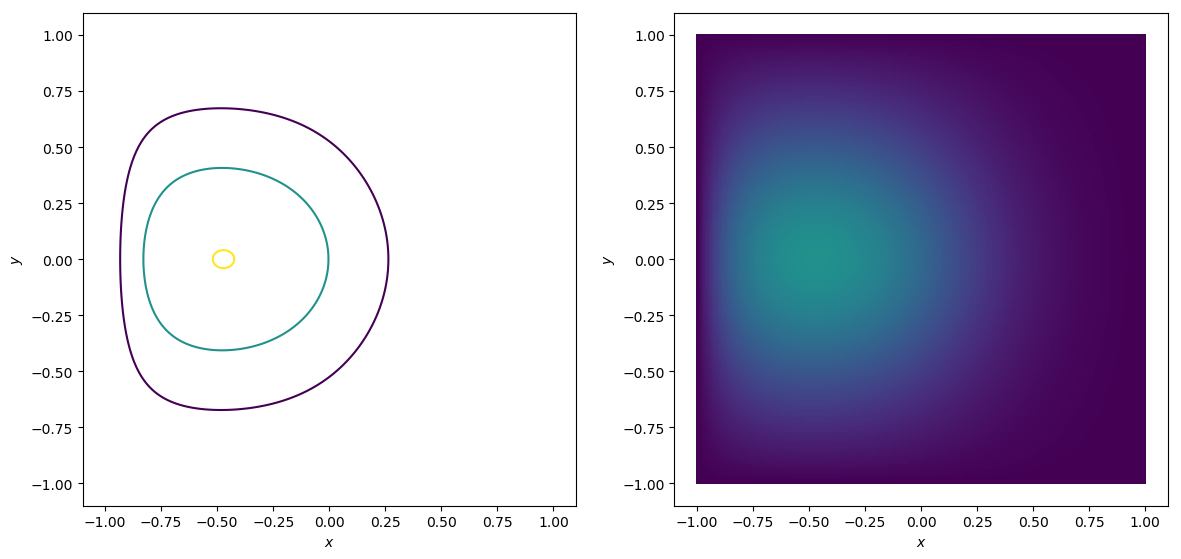

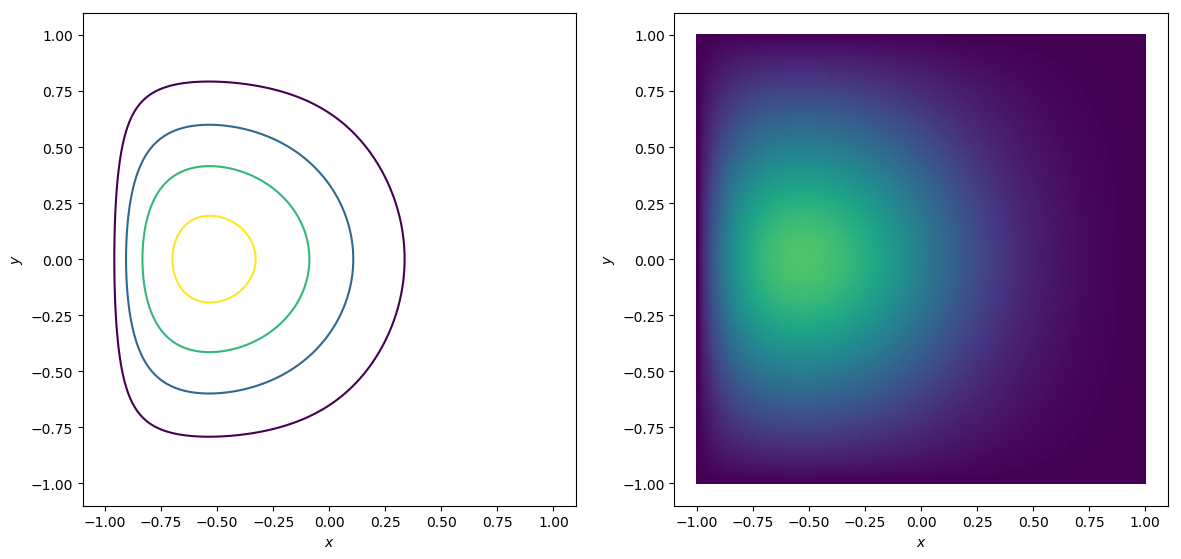

In [37]:
c⁺, c⁻ = maximum(map(maximum, 𝒇ₚ)), minimum(map(minimum, 𝒇ₚ))

for k ∈ 1:10:nₜ
    figure(figsize= (14, 8))
    
    subplot(121)
    contour(𝑥, 𝑦, reshape(𝒇ₚ[k], nₓ, nₓ), linspace(c⁻, c⁺, 7))
    set_layout()
    
    subplot(122)
    pcolor(𝑥, 𝑦, reshape(𝒇ₚ[k], nₓ, nₓ))
    clim(c⁻,c⁺)
    set_layout()
end